In [1]:
import reskit as rk
import pandas as pd
import pvlib
import geokit as gk
import xarray as xr
import netCDF4 as nc
from reskit import WorkflowManager

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
placements = pd.DataFrame()
placements['name'] = ['Building1', 'Building2', 'Building3', 'Building4', 'Building5']
placements['lon'] = [ 36.24558, 36.24583, 36.24609, 36.24623, 36.24637]     # Longitude
placements['lat'] = [ 28.16104, 28.16113, 28.16120, 28.16137, 28.16109]    # Latitude
placements['tilt'] = [ 90, 90, 90, 90, 90]   # System tilt in degrees (based on paper and annual energy demand profile)
placements['azimuth'] = [ 100, 100, 100, 100, 100 ]# System azimuth in degrees (orientation) NEE facing
placements['capacity'] = [ 5.285, 1.468, 5.285, 0, 0 ] # Total system capacity in kW for each building balony facade area and assuming 2sqm panels
placements['elev'] = [ 0, 0, 0, 0, 0 ]      # Altitute in meters

placements

,name,lon,lat,tilt,azimuth,capacity,elev
0,Building1,36.24558,28.16104,90,100,5.285,0
1,Building2,36.24583,28.16113,90,100,1.468,0
2,Building3,36.24609,28.16120,90,100,5.285,0
3,Building4,36.24623,28.16137,90,100,0.000,0
4,Building5,36.24637,28.16109,90,100,0.000,0


In [3]:
src_sarah=rk.weather.SarahSource(r"/Users/zaramulholland/reskit/reskit/_test/data/SARAH_try"),
src_era5=rk.weather.Era5Source(r"/Users/zaramulholland/reskit/reskit/_test/data/ERA5_try")

/Users/zaramulholland/reskit/reskit/_test/data/SARAH_try/SARAH-DNI.rhodes.y2016.nc
/Users/zaramulholland/reskit/reskit/_test/data/SARAH_try/SARAH-SIS.rhodes.y2016.nc
/Users/zaramulholland/reskit/reskit/_test/data/ERA5_try/reanalysis-era5-single-levels.rhodes.y2016.10m_wind_speed.processed.nc
/Users/zaramulholland/reskit/reskit/_test/data/ERA5_try/reanalysis-era5-single-levels.rhodes.y2016.2m_dewpoint_temperature.nc
/Users/zaramulholland/reskit/reskit/_test/data/ERA5_try/reanalysis-era5-single-levels.rhodes.y2016.2m_temperature.nc
/Users/zaramulholland/reskit/reskit/_test/data/ERA5_try/reanalysis-era5-single-levels.rhodes.y2016.surface_pressure.nc


In [4]:
sim_result = rk.solar.openfield_pv_sarah_unvalidated(
    placements=placements,
    sarah_path=r"/Users/zaramulholland/reskit/reskit/_test/data/SARAH_try",
    era5_path=r"/Users/zaramulholland/reskit/reskit/_test/data/ERA5_try",
    module='ONYX_SOLAR_ENERGY_S_L__ONYX_G_G_M06666',
    tracking='fixed'
)

# OR ONYX SOLAR ENERGY S.L. ONYX G/G M06666



/Users/zaramulholland/opt/anaconda3/envs/reskit/lib/python3.8/site-packages/pvlib/irradiance.py:1059: RuntimeWarning: divide by zero encountered in true_divide
  eps = ((dhi + dni) / dhi + kappa * (z ** 3)) / (1 + kappa * (z ** 3))


In [5]:
output_df = sim_result['capacity_factor'].fillna(0).to_dataframe().unstack()


In [6]:
output_df.index = output_df.index.tz_localize(tz='UTC').tz_convert(tz='Europe/Athens')

In [7]:
output_df.columns = [('Building1'),
            ('Building2'), 
            ('Building3'),
            ('Building4'),
            ('Building5')]

In [8]:
output_df.columns

Index(['Building1', 'Building2', 'Building3', 'Building4', 'Building5'], dtype='object')

In [9]:
output_df = output_df.resample('h').sum()

In [10]:
output_df

,Building1,Building2,Building3,Building4,Building5
time,,,,,
2016-01-01 02:00:00+02:00,0.0,0.0,0.0,0.0,0.0
2016-01-01 03:00:00+02:00,0.0,0.0,0.0,0.0,0.0
2016-01-01 04:00:00+02:00,0.0,0.0,0.0,0.0,0.0
2016-01-01 05:00:00+02:00,0.0,0.0,0.0,0.0,0.0
2016-01-01 06:00:00+02:00,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
2016-12-31 21:00:00+02:00,0.0,0.0,0.0,0.0,0.0
2016-12-31 22:00:00+02:00,0.0,0.0,0.0,0.0,0.0
2016-12-31 23:00:00+02:00,0.0,0.0,0.0,0.0,0.0


In [11]:
#output_df.to_csv("/Users/zaramulholland/reskit/PV_BALC.csv")

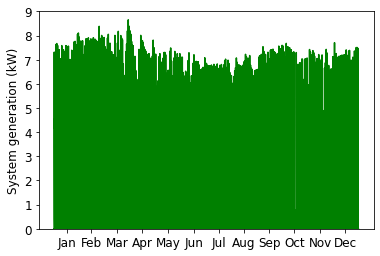

In [15]:
output_df =sim_result['total_system_generation'].sum("location")

plt.plot(output_df, color='green')

plt.ylabel("System generation (kW)", )
plt.rcParams.update({'font.size': 12})
#positions = (744, 1416, 2160, 2880, 3624, 4344, 5088, 5832, 6552, 7296, 8016, 8760)
positions = (744, 2160, 3648, 5088, 6576, 8100, 9504, 10944, 12432, 13873, 15360, 16806)
labels = ("Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec")
plt.xticks(positions, labels)
plt.ylim(0, 9)
plt.savefig("BALC_Generation", dpi=800)